## Set Up

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext version_information
%version_information pandas, numpy, matplotlib, seaborn, json

Software versions
Python 3.5.2 64bit [GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
IPython 5.1.0
OS Darwin 16.1.0 x86_64 i386 64bit
pandas 0.18.1
numpy 1.11.1
matplotlib 1.5.3
seaborn 0.7.1
json 2.0.9
Thu Mar 16 22:40:42 2017 PDT

In [3]:
# customized plot style
s = json.load( open("plot_style.json") )
matplotlib.rcParams.update(s)

## Get Data

This data is from the California Safe Cosmetics Program (CSCP) in the California Department of Public Health, downloaded from [HealthData.gov](https://www.healthdata.gov/dataset/chemicals-cosmetics).

In [4]:
chemical = pd.read_csv('Chemicals_in_Cosmetics.csv')
print(chemical.shape)
chemical.head(3)

(80004, 22)


,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,24969,CoverGirl Outlast Illumina All Day Lipcolor,38098.0,Luminous Lilac,86,The Procter & Gamble Company,CoverGirl,44,Makeup Products (non-permanent),53,...,13463-67-7,38700,Titanium dioxide,01/07/2015 12:00:00 AM,01/07/2015 12:00:00 AM,NaN,01/07/2015 12:00:00 AM,01/07/2015 12:00:00 AM,NaN,1
1,960,Liner Shadow,45015.0,Bark,84,"Bare Escentuals Beauty, Inc.",bareMinerals,44,Makeup Products (non-permanent),48,...,13463-67-7,1047,Titanium dioxide,09/15/2009 12:00:00 AM,09/02/2016 12:00:00 AM,NaN,09/15/2009 12:00:00 AM,09/02/2016 12:00:00 AM,NaN,1
2,25882,Lip Gloss (FLAB-0048),NaN,NaN,1000,MAESA LLC,Candies,44,Makeup Products (non-permanent),53,...,NaN,40424,"Mineral oils, untreated and mildly treated",04/01/2015 12:00:00 AM,11/02/2015 12:00:00 AM,04/01/2015 12:00:00 AM,04/01/2015 12:00:00 AM,04/01/2015 12:00:00 AM,NaN,3


In [5]:
# columns of the dataset
print(chemical.columns.values)

['CDPHId' 'ProductName' 'CSFId' 'CSF' 'CompanyId' 'CompanyName' 'BrandName'
 'PrimaryCategoryId' 'PrimaryCategory' 'SubCategoryId' 'SubCategory'
 'CasId' 'CasNumber' 'ChemicalId' 'ChemicalName' 'InitialDateReported'
 'MostRecentDateReported' 'DiscontinuedDate' 'ChemicalCreatedAt'
 'ChemicalUpdatedAt' 'ChemicalDateRemoved' 'ChemicalCount']


## Data Cleaning

In [6]:
# inconsistent upper and lower cases for string values are found - convert all of them to lower case
to_be_converted = ['ProductName', 'CompanyName', 'BrandName', 'PrimaryCategory', 'SubCategory', \
                   'ChemicalName']
for column in to_be_converted:
    chemical[column] = chemical[column].str.lower()

### 1. Missing Data

In [7]:
# 'none' values are found in 'BrandName' column - convert them to NaN
chemical.loc[chemical['BrandName'] == 'none', 'BrandName'] = np.nan

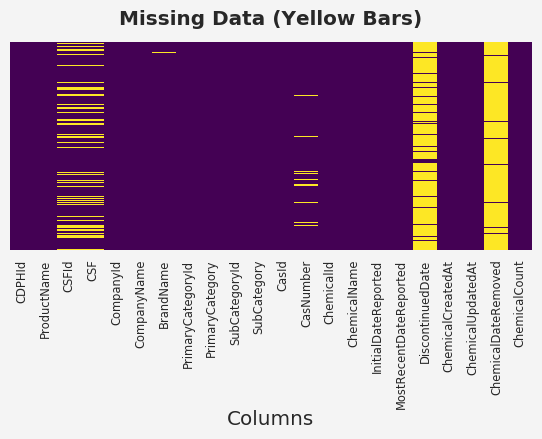

In [8]:
# visualize missing data
p = plt.figure(figsize = (6, 2.5))
p = sns.heatmap(pd.isnull(chemical), yticklabels=False, cbar=False, cmap='viridis')
p.set(xlabel = 'Columns')
p.set_title('Missing Data (Yellow Bars)', fontweight = 'bold', y = 1.05)

- Majority of the rows are missing for `'DiscontinuedDate'` and `'ChemicalDateRemoved'`: they are probably just not applicable (products still on sale and no reformulation has been done)  
- Quite a few `'CSFId'`, `'CSF'` and `'CasId'` are missing: I do not have enough knowledge to fill in these values but deleting the rows with these numbers missing would cause problem; leave as they are.
- `'BrandName'` is a column of interest: try to fill in missing value using information given in the data, e.g., `'CompanyName'`

In [9]:
# try to fill in the missing values in 'BrandName' column

# subset of rows with missing BrandName
brand_missing = chemical[pd.isnull(chemical.BrandName)]
print(brand_missing.shape)
brand_missing.head()

(225, 22)


,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
3468,1188,lasting eyecolor,1715.0,Ivory,91,merle norman cosmetics,NaN,44,makeup products (non-permanent),48,...,13463-67-7,1309,titanium dioxide,09/19/2009 12:00:00 AM,11/22/2011 12:00:00 AM,11/22/2011 12:00:00 AM,09/19/2009 12:00:00 AM,09/19/2009 12:00:00 AM,NaN,1
3469,1188,lasting eyecolor,1716.0,Ice,91,merle norman cosmetics,NaN,44,makeup products (non-permanent),48,...,13463-67-7,1309,titanium dioxide,09/19/2009 12:00:00 AM,11/22/2011 12:00:00 AM,11/22/2011 12:00:00 AM,09/19/2009 12:00:00 AM,09/19/2009 12:00:00 AM,NaN,1
3470,1188,lasting eyecolor,1717.0,Brass,91,merle norman cosmetics,NaN,44,makeup products (non-permanent),48,...,13463-67-7,1309,titanium dioxide,09/19/2009 12:00:00 AM,11/22/2011 12:00:00 AM,11/22/2011 12:00:00 AM,09/19/2009 12:00:00 AM,09/19/2009 12:00:00 AM,NaN,1
3471,1188,lasting eyecolor,1718.0,Buff,91,merle norman cosmetics,NaN,44,makeup products (non-permanent),48,...,13463-67-7,1309,titanium dioxide,09/19/2009 12:00:00 AM,11/22/2011 12:00:00 AM,11/22/2011 12:00:00 AM,09/19/2009 12:00:00 AM,09/19/2009 12:00:00 AM,NaN,1
3472,1188,lasting eyecolor,1719.0,Lava,91,merle norman cosmetics,NaN,44,makeup products (non-permanent),48,...,13463-67-7,1309,titanium dioxide,09/19/2009 12:00:00 AM,11/22/2011 12:00:00 AM,11/22/2011 12:00:00 AM,09/19/2009 12:00:00 AM,09/19/2009 12:00:00 AM,NaN,1


In [10]:
# since the company names of all these rows are know, groupby CompanyName 
grouped = brand_missing.groupby('CompanyName', sort=False).size().sort_values(ascending=False).reset_index()
grouped.columns = ['CompanyName', 'Count']

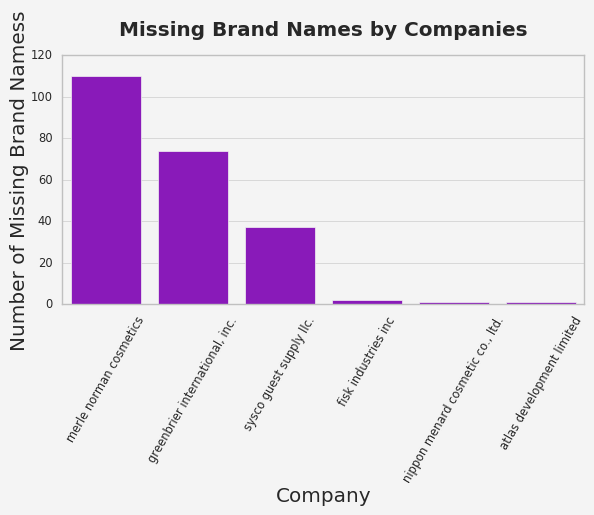

In [11]:
# plot number of Missing Brand Names by Companies
p = sns.barplot(x='CompanyName', y = 'Count', data=grouped, color='darkviolet')
p.set(xlabel = 'Company', ylabel = 'Number of Missing Brand Namess')
p.set_title('Missing Brand Names by Companies', fontweight='bold', y = 1.05)
for item in p.get_xticklabels():
    item.set_rotation(60)

In [12]:
# fill in missing brand names based on the knowledge from the company name
chemical.loc[chemical['CompanyName'] == 'merle norman cosmetics', 'BrandName'] = 'merle norman'
chemical.loc[chemical['CompanyName'] == 'nippon menard cosmetic co., ltd.', 'BrandName'] = 'nippon menard'
chemical.loc[chemical['CompanyName'] == 'fisk industries inc', 'BrandName'] = 'zuri flawless'

In [13]:
# fill in the rest of missing brand names of 'unknown'
chemical.loc[chemical['CompanyName'] == 'greenbrier international, inc', 'BrandName'] = 'unknown'
chemical.loc[chemical['CompanyName'] == 'sysco guest supply llc.', 'BrandName'] = 'unknown'
chemical.loc[chemical['CompanyName'] == 'atlas development limited', 'BrandName'] = 'unknown'

### 2. Duplicates

In [14]:
# number of duplicated rows
chemical.duplicated().sum()

251

In [15]:
# check if there is anything in common in these duplicated row
duplicates = chemical[chemical.duplicated()]
duplicates.head()

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
14738,3488,chi scentuals mango melon hand and body wash,NaN,NaN,120,"farouk systems, inc.",chi,6,bath products,159,...,0,0,trade secret,10/12/2009 12:00:00 AM,10/12/2009 12:00:00 AM,NaN,10/12/2009 12:00:00 AM,10/12/2009 12:00:00 AM,NaN,1
14745,3494,chi scentuals lavender latte hand and body wash,NaN,NaN,120,"farouk systems, inc.",chi,6,bath products,159,...,0,0,trade secret,10/12/2009 12:00:00 AM,10/12/2009 12:00:00 AM,NaN,10/12/2009 12:00:00 AM,10/12/2009 12:00:00 AM,NaN,1
14768,3506,chi scentuals coconut lime hand and body wash,NaN,NaN,120,"farouk systems, inc.",chi,6,bath products,159,...,0,0,trade secret,10/12/2009 12:00:00 AM,10/12/2009 12:00:00 AM,NaN,10/12/2009 12:00:00 AM,10/12/2009 12:00:00 AM,NaN,1
14882,3576,chi ionic permanent shine hair color 1n - black,NaN,NaN,120,"farouk systems, inc.",chi,32,hair coloring products,35,...,0,0,trade secret,10/12/2009 12:00:00 AM,10/12/2009 12:00:00 AM,NaN,10/12/2009 12:00:00 AM,10/12/2009 12:00:00 AM,NaN,1
14889,3583,chi ionic permanent shine hair color 2n - natu...,NaN,NaN,120,"farouk systems, inc.",chi,32,hair coloring products,35,...,0,0,trade secret,10/12/2009 12:00:00 AM,10/12/2009 12:00:00 AM,NaN,10/12/2009 12:00:00 AM,10/12/2009 12:00:00 AM,NaN,1


In [16]:
# unique company names in these duplicated rows
duplicates.CompanyName.unique()

array(['farouk systems, inc.', 'regis corporation', 'great clips, inc.',
       'lumene oy', 'demeter fragrance library, inc.',
       'jan marini skin research, inc.'], dtype=object)

In [17]:
# unique brand names in these duplicated rows
duplicates.BrandName.unique()

array(['chi', 'regis design line', 'sunglitz', 'bioglitz',
       'bioglitz color', 'detour - great clips',
       'solutions by great clips', 'lumene', 'demeter', '880620',
       'jan marini skin research'], dtype=object)

In [18]:
# note '880620' above 
# it is not a typical brand name, so look at the entire row
chemical[chemical['BrandName'] == '880620']

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
69097,13047,880620\tlumene dream lips age-defying lip care...,NaN,NaN,629,lumene oy,880620,44,makeup products (non-permanent),51,...,0,0,trade secret,06/23/2010 12:00:00 AM,06/23/2010 12:00:00 AM,NaN,06/23/2010 12:00:00 AM,06/23/2010 12:00:00 AM,NaN,1
69098,13047,880620\tlumene dream lips age-defying lip care...,NaN,NaN,629,lumene oy,880620,44,makeup products (non-permanent),51,...,0,0,trade secret,06/23/2010 12:00:00 AM,06/23/2010 12:00:00 AM,NaN,06/23/2010 12:00:00 AM,06/23/2010 12:00:00 AM,NaN,1


Clearly, it is actually an error in the data

In [19]:
# correct these two rows
chemical.loc[chemical['BrandName'] == '880620', 'ProductName'] = 'lumene dream lips age-defying lip care 15ml'
chemical.loc[chemical['BrandName'] == '880620', 'BrandName'] = 'lumene'

In [20]:
# These duplicates do not look suspecious, so simply drop them
chemical = chemical.drop_duplicates()
print(chemical.shape)

(79753, 22)


### 3. Some Facts about the Cleaned Dataset

In [21]:
unique_CDPHId = chemical.CDPHId.nunique()
unique_companyname = chemical.CompanyName.nunique()
unique_brandname = chemical.BrandName.nunique()
unique_productname = chemical.ProductName.nunique()
unique_chemicalname = chemical.ChemicalName.nunique()
unique_primarycategory = chemical.PrimaryCategory.nunique()
unique_subcategory = chemical.SubCategory.nunique()

print('Number of unique CDPHId: {}'.format(unique_CDPHId))
print('Number of unique company names: {}'.format(unique_companyname))
print('Number of unique brand names: {}'.format(unique_brandname))
print('Number of unique product names: {}'.format(unique_productname))
print('Number of unique primary category names: {}'.format(unique_primarycategory))
print('Number of unique sub category names: {}'.format(unique_subcategory))
print('Number of unique toxic chemical names: {}'.format(unique_chemicalname))

Number of unique CDPHId: 26036
Number of unique company names: 508
Number of unique brand names: 1820
Number of unique product names: 23992
Number of unique primary category names: 13
Number of unique sub category names: 89
Number of unique toxic chemical names: 110


- Further inspection of the data shows that `'CDPHId'` represent unique products
- Number of unique product names < Number of unique CDPHId. Why? There must be different products with the same names.

In [22]:
# keep a seperate dataframe for unique products
products = chemical[['CDPHId', 'CompanyName', 'BrandName', 'ProductName']].drop_duplicates()

# use brandname + productname as the full product name
products['fullProductName'] = products['BrandName'] + ' - ' + products['ProductName']

# check if we have the correct number of products
products.shape[0] == chemical.CDPHId.nunique()

True

## Data Visualization

### Questions of interest
1. What are the most common reportable chemicals in these reports?
2. Which products have the largest number of reportable chemicals reported?
3. Which categories of cosmetic products are reported most frequently?
4. Which companies have the largest number of products reported?
5. Which brands have the largest number of products reported?  

#### 1.  What are the most common reportable chemicals in these reports?

In [23]:
# rename this very long chemical name
chemical.loc[chemical['ChemicalName'] == 'retinol/retinyl esters, when in daily dosages in excess of 10,000 iu, or 3,000 retinol equivalents.', 'ChemicalName'] = 'retinol/retinyl esters'

In [24]:
# groupby ChemicalName and count the number of unique products
bychemical = chemical.groupby('ChemicalName').CDPHId.nunique().reset_index()
bychemical = bychemical.sort_values('CDPHId', ascending=False)

In [25]:
bychemical['logCount'] = np.log10(bychemical.CDPHId)

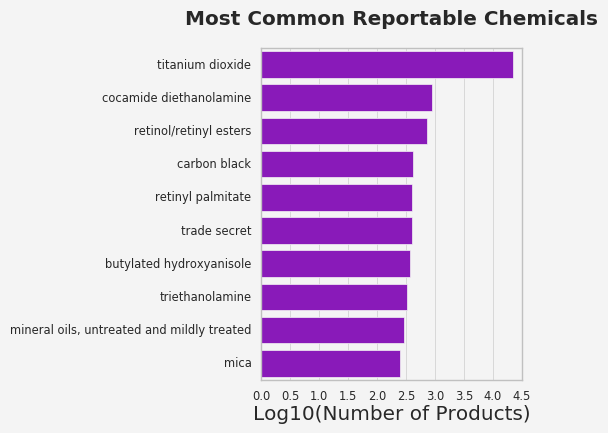

In [26]:
# plot most common (top 10) toxic chemicals
p = plt.figure(figsize = (3, 4))
p = sns.barplot(x = 'logCount', y = 'ChemicalName', data = bychemical[:10], color = 'darkviolet')
p.set(xlabel = 'Log10(Number of Products)', ylabel = '')
p.set_title('Most Common Reportable Chemicals', fontweight = 'bold', y = 1.05)

Looks like titanium dioxide is contained in the majority of the products reported. The exact harm of titanium dioxide is not well understood. It is generally considered to be a relatively inert, safe material, but when it is in the form of nanoparticles, some believe that it can penetrate the skin and lead to potential health risk. Currently, only airborne, unbound titanium dioxide particle of respirable size is officially listed in [California Proposition 65](https://oehha.ca.gov/proposition-65/about-proposition-65). 

All other chemicals are contained in much smaller number of products. The health risks for some of them are also controversial. FDA actually only takes legal action against cosmetic companies if there is enough evidence of a safety problem for consumers. 

#### 2. Which products have the largest number of reportable chemicals reported?

In [27]:
# count unique chemical names in each product
byproduct = chemical.groupby(['CDPHId']).ChemicalName.nunique().reset_index()

In [28]:
print('Minimum number of reportable chemicals in any product: {}'.format(byproduct.ChemicalName.min()))
print('Maximum number of reportable chemicals in any product: {}'.format(byproduct.ChemicalName.max()))
print('Median number of reportable chemicals in all product: {}'.format(byproduct.ChemicalName.median()))
print('Mean number of reportable chemicals in all product: {}'.format(byproduct.ChemicalName.mean()))
print('Standard deviation of the number of reportable chemicals in all product: {}'.format(byproduct.ChemicalName.std()))

Minimum number of reportable chemicals in any product: 1
Maximum number of reportable chemicals in any product: 10
Median number of reportable chemicals in all product: 1.0
Mean number of reportable chemicals in all product: 1.0970579198033492
Standard deviation of the number of reportable chemicals in all product: 0.3771734727730194


Looks like the majority of products in the dataset only contains one reportable chemical (highly likely to be titanium dioxide), but there are also products contain more than one reportable chemicals. What are they?

In [29]:
merged = products.merge(byproduct, on = 'CDPHId')

# define 'bad' products as those with more than 5 different toxic chemicals
products_bad = merged[merged['ChemicalName'] >= 5]
products_bad = products_bad.sort_values('ChemicalName', ascending = False)

In [30]:
# change a long name
products_bad.loc[products_bad['BrandName'] == "nature's gate", 'fullProductName'] = "nature's gate - sunblock spf 30 tropical scent sunscreen lotion"

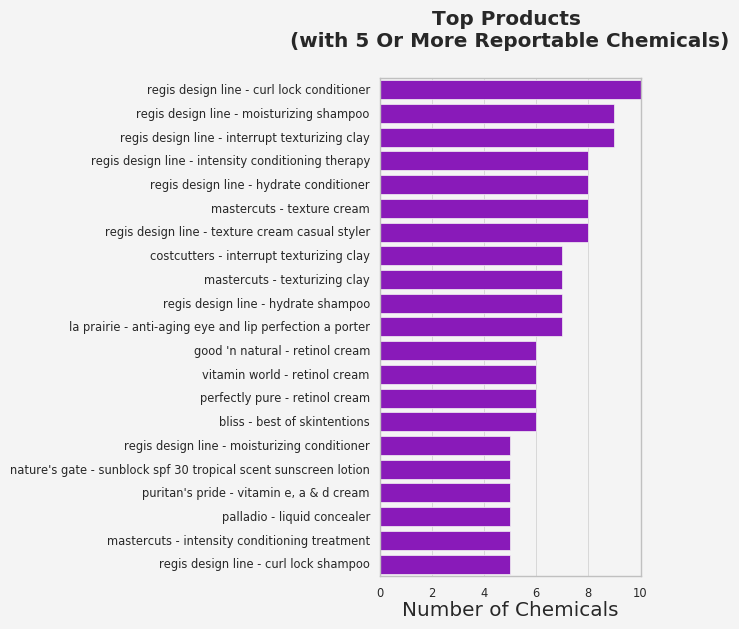

In [31]:
# plot these product
p = plt.figure(figsize = (3, 6))
p = sns.barplot(x = 'ChemicalName', y = 'fullProductName', data = products_bad, color = 'darkviolet')
p.set(xlabel = 'Number of Chemicals', ylabel = '')
p.set_title('Top Products \n(with 5 Or More Reportable Chemicals)', fontweight = 'bold', y = 1.05)

A lot of them are hair and skin care products!

#### 3. Which categories of cosmetic products are reported most frequently?

In [32]:
# count the number of products by primary category
bycategory = chemical.drop_duplicates('CDPHId')
bycategory = bycategory.groupby('PrimaryCategory', sort=False).size().sort_values(ascending=False).reset_index()
bycategory.columns = ['PrimaryCategory', 'Count']

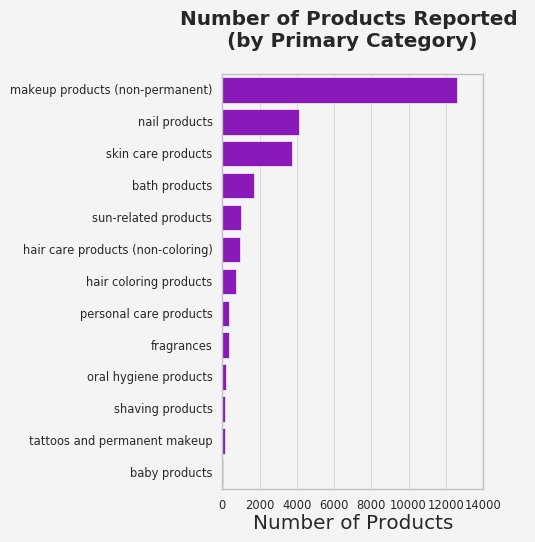

In [33]:
# plot Number of Reported Products by Primary Category
p = plt.figure(figsize = (3, 5))
p = sns.barplot(x = 'Count', y = 'PrimaryCategory', data = bycategory, color = 'darkviolet')
p.set(xlabel = 'Number of Products', ylabel = '')
p.set_title('Number of Products Reported \n(by Primary Category)', fontweight = 'bold', y = 1.05)

#### 4. Which companies have the largest number of products reported?

In [34]:
# group by companies
bycompany = products.groupby('CompanyName', sort=False).size().sort_values(ascending=False).reset_index()
bycompany.columns = ['CompanyName', 'Count']

In [35]:
bycompany.loc[bycompany['CompanyName'] == 'markwins international, markwins beauty products, physicians formula', 'CompanyName'] = 'Markwins International'

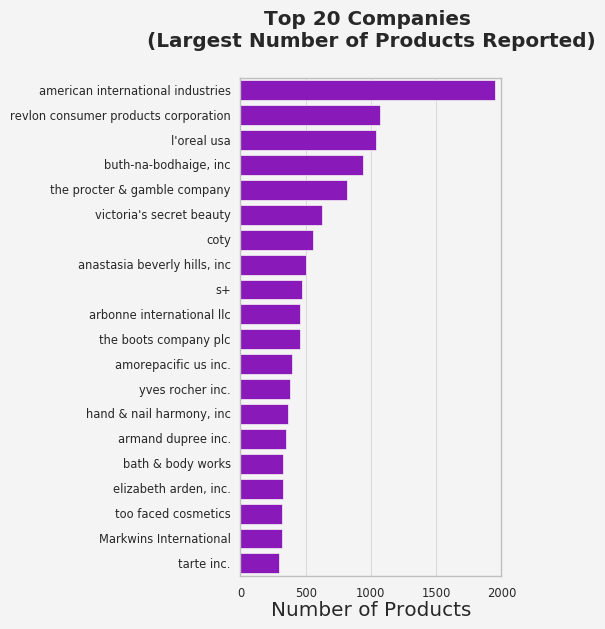

In [36]:
p = plt.figure(figsize = (3, 6))
p = sns.barplot(x = 'Count', y = 'CompanyName', data = bycompany[:20], color = 'darkviolet')
p.set(xlabel = 'Number of Products', ylabel = '')
p.set_title('Top 20 Companies \n(Largest Number of Products Reported)', fontweight = 'bold', y = 1.05)

#### 5. Which brands have the largest number of products reported?  

In [37]:
# group by brand and count number of products
bybrand = products.groupby('BrandName', sort=False).size().sort_values(ascending=False).reset_index()
bybrand.columns = ['BrandName', 'Count']

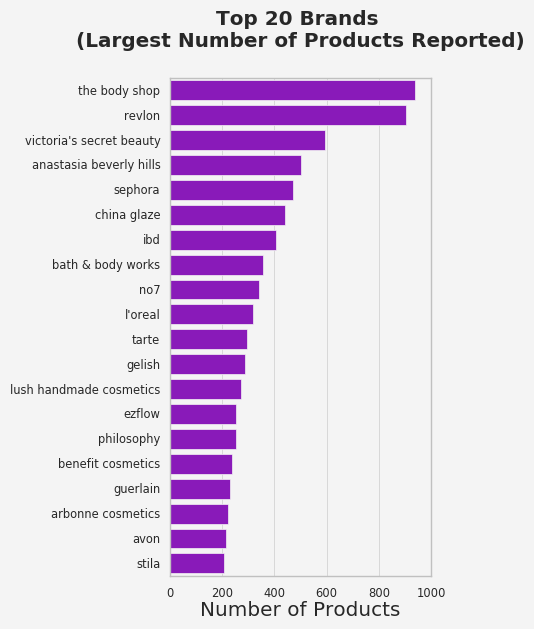

In [38]:
# plot Top 20 Brands with the Most Reported Products
p = plt.figure(figsize = (3, 6))
p = sns.barplot(x = 'Count', y = 'BrandName', data = bybrand[:20], color = 'darkviolet')
p.set(xlabel = 'Number of Products', ylabel = '')
p.set_title('Top 20 Brands \n(Largest Number of Products Reported)', fontweight = 'bold', y = 1.05)

### Discontinued Products

In [39]:
discontinued = chemical[pd.notnull(chemical.DiscontinuedDate)]
print(discontinued.shape)
discontinued.head()

(9583, 22)


,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
2,25882,lip gloss (flab-0048),NaN,NaN,1000,maesa llc,candies,44,makeup products (non-permanent),53,...,NaN,40424,"mineral oils, untreated and mildly treated",04/01/2015 12:00:00 AM,11/02/2015 12:00:00 AM,04/01/2015 12:00:00 AM,04/01/2015 12:00:00 AM,04/01/2015 12:00:00 AM,NaN,3
3,9247,02 concealer,NaN,NaN,77,"buth-na-bodhaige, inc",the body shop,44,makeup products (non-permanent),50,...,13463-67-7,14193,titanium dioxide,12/22/2009 12:00:00 AM,02/19/2014 12:00:00 AM,02/19/2014 12:00:00 AM,12/22/2009 12:00:00 AM,12/22/2009 12:00:00 AM,NaN,1
37,17115,01 the sparkler shade: boudoir pink,NaN,NaN,77,"buth-na-bodhaige, inc",the body shop,90,skin care products,98,...,14808-60-7,34832,quartz,10/04/2011 12:00:00 AM,05/13/2014 12:00:00 AM,05/13/2014 12:00:00 AM,05/13/2014 12:00:00 AM,05/13/2014 12:00:00 AM,NaN,2
239,5656,burt�s bees tinted lip balm,30362.0,Petunia,305,burt's bees inc.,burt�s bees,44,makeup products (non-permanent),51,...,13463-67-7,9542,titanium dioxide,10/15/2009 12:00:00 AM,01/05/2016 12:00:00 AM,12/25/2011 12:00:00 AM,10/15/2009 12:00:00 AM,09/05/2013 12:00:00 AM,09/05/2013 12:00:00 AM +0000,1
300,9352,nail colour 05 shade: iced grape,NaN,NaN,77,"buth-na-bodhaige, inc",the body shop,59,nail products,65,...,13463-67-7,14301,titanium dioxide,12/24/2009 12:00:00 AM,07/10/2013 12:00:00 AM,07/10/2013 12:00:00 AM,12/24/2009 12:00:00 AM,12/24/2009 12:00:00 AM,NaN,1


## Summary

- The potential risks of a lot of the chemicals are actually controversial and FDA does not take legal action against cosmetic companies unless there is enough evidence. So it is really up to us to decide whether we want to avoid some ingredients or not.
- Compared to products with only one chemical reported like titanium dioxide (commonly used in sunscreens and makeups; probably hard to avoid), we should probably be more cautious about products containing several different kinds of potentially dangerous chemicals.
- According to the dataset, makeup is the No.1 category with the most products reported to have potentially dangerous chemicals and baby products seem to be the “safest”. The former is not surprising to most of us and the latter is reassuring.